# Наша неудачная модель 

Импортируем библиотеки необходимые нам для проверки об

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

### Загружаем данные

In [5]:
df = pd.read_excel("train.xlsx")

### Проверяем данные на их тип количество и пропуски


In [6]:
print(df.head(-1))
print("="*50)
print(df.info())
print("="*50)
print(df.isnull().sum())

            dt  Цена на арматуру
0   2015-01-05             32900
1   2015-01-12             32500
2   2015-01-19             32000
3   2015-01-26             30700
4   2015-02-02             30300
..         ...               ...
394 2022-07-25             47500
395 2022-08-01             47500
396 2022-08-08             49000
397 2022-08-15             47500
398 2022-08-22             46500

[399 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB
None
dt                  0
Цена на арматуру    0
dtype: int64


### Устанавливаем дату как индекс

In [7]:

df.set_index("dt", inplace=True)

### Выводим график выданных нам данные  где видно цену и год

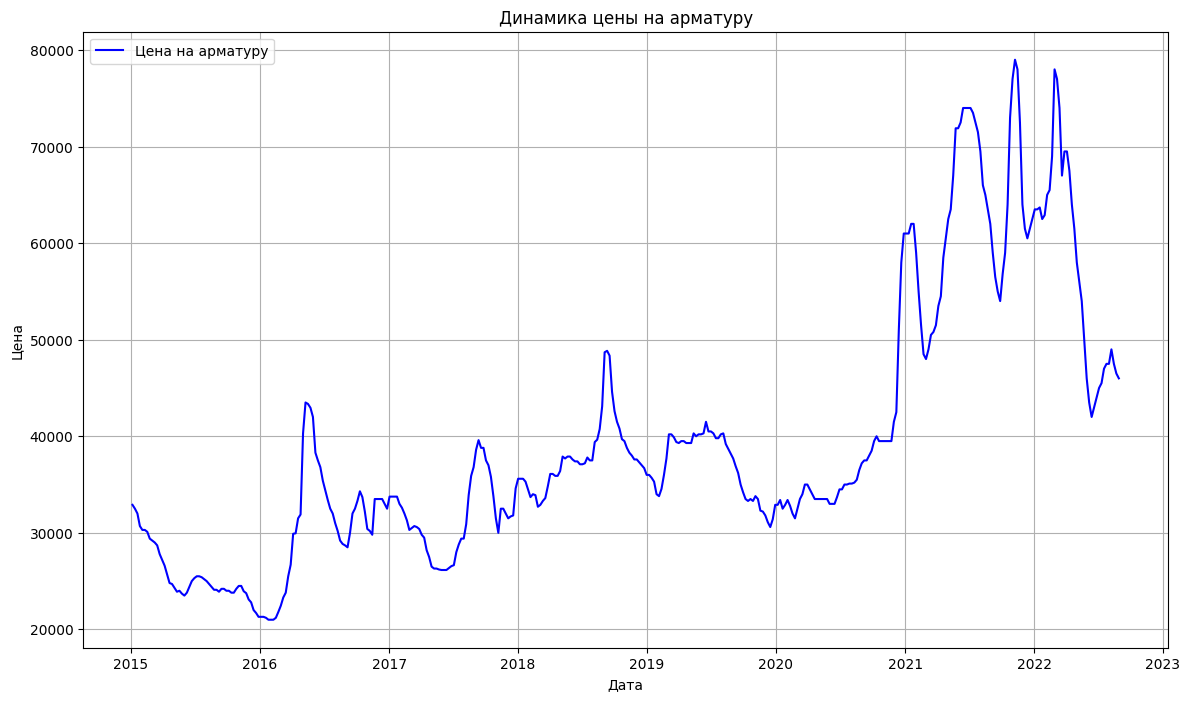

In [8]:
plt.figure(figsize=(14, 8))
plt.plot(df.index, df["Цена на арматуру"], label="Цена на арматуру", color="b")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Динамика цены на арматуру")
plt.legend()
plt.grid()
plt.show()

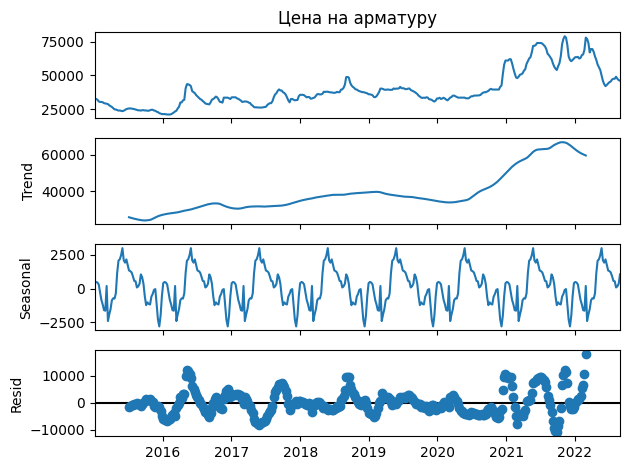

In [9]:
decomposition = seasonal_decompose(df["Цена на арматуру"], model="additive", period=52)
decomposition.plot()
plt.show()

In [10]:
df["month"] = df.index.month  # месяц
df["year"] = df.index.year    # год
df["week"] = df.index.isocalendar().week  

### Создаем модельку с учетом его параметров

In [11]:
model = SARIMAX(df["Цена на арматуру"],
                order=(1, 1, 1),   
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False, 
                enforce_invertibility=False)

c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


### Обучаем модельку на всех данных когда делишь данные предсказание на будующее становится хуже

In [12]:

sarimax_model = model.fit(disp=False)
residuals = sarimax_model.resid




### Предсказываем на 30 шагов вперед
### Используем обученную модель
### Создает индекс для прогноза, который будет соответствовать датам для будущих периодов

In [13]:
forecast_steps = 30
forecast = sarimax_model.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='W')[1:]

### Предсказание и возможные калебания 

In [14]:
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

           dt  Цена на арматуру
0  2022-09-05             46000
1  2022-09-12             46000
2  2022-09-19             46000
3  2022-09-26             45500
4  2022-10-03             45500
5  2022-10-10             45000
6  2022-10-17             44000
7  2022-10-24             43000
8  2022-10-31             42000
9  2022-11-07             41500
10 2022-11-14             41000
11 2022-11-21             40000
12 2022-11-28             40000
13 2022-12-05             40500
14 2022-12-12             41700
15 2022-12-19             41700
16 2022-12-26             42500
17 2023-01-02             42700
18 2023-01-09             42700
19 2023-01-16             42700
20 2023-01-23             42800
21 2023-01-30             42800
22 2023-02-06             44500
23 2023-02-13             44500
24 2023-02-20             46000
25 2023-02-27             49200
26 2023-03-06             53700


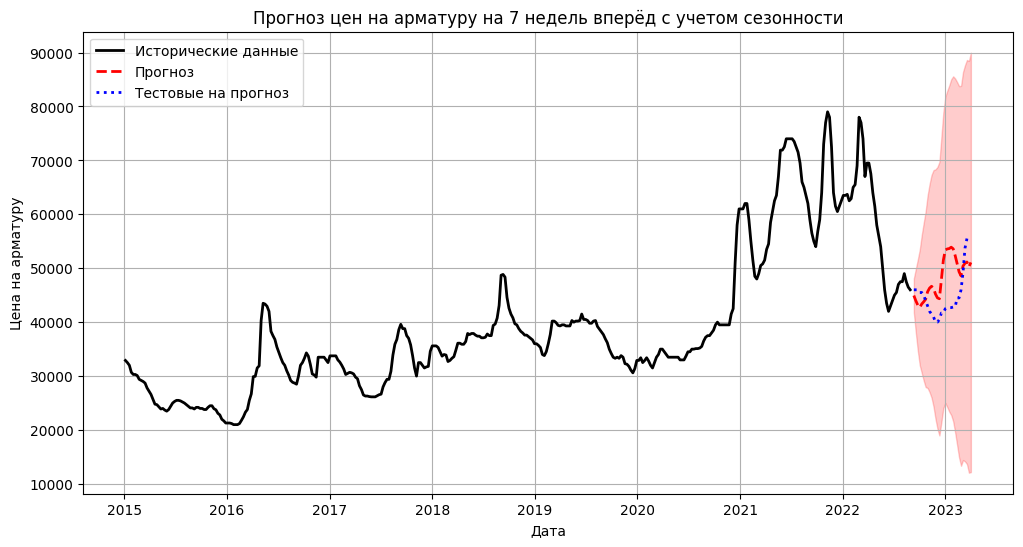

In [15]:


test_data = pd.read_excel("test.xlsx")
print(test_data.head(-1))

test_data.index = forecast_index[:len(test_data)]

plt.figure(figsize=(12, 6))

plt.plot(df.index, df["Цена на арматуру"], label="Исторические данные", color="black", linewidth=2)

plt.plot(forecast_index, forecast_mean, label="Прогноз", color="red", linestyle="--", linewidth=2)
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=0.2)


plt.plot(test_data.index, test_data["Цена на арматуру"], label="Тестовые на прогноз", color="blue", linestyle=":", linewidth=2)


plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цен на арматуру на 7 недель вперёд с учетом сезонности")
plt.legend()
plt.grid()
plt.show()

y_true = df["Цена на арматуру"].iloc[-forecast_steps:]
mae = mean_absolute_error(y_true, forecast_mean)
r2 = r2_score(y_true, forecast_mean)




график прогноза повторяет но раньше положенного времени и с меньшим диапозоном


In [ ]:
# import joblib
# import pandas as pd

# # 1. Сохранение прогноза в Excel
# forecast_data = pd.DataFrame({
#     "Дата": forecast_index,
#     "Цена на арматуру (Прогноз)": forecast_mean,
#     "Нижний интервал": forecast_ci.iloc[:, 0],
#     "Верхний интервал": forecast_ci.iloc[:, 1]
# })

# # Сохранение в Excel
# forecast_data.to_excel("forecast_results.xlsx", index=False)
# print("Прогноз сохранен в файл 'forecast_results.xlsx'.")

# # 2. Сохранение модели
# # Сохраняем модель SARIMAX с помощью joblib
# joblib.dump(sarimax_model, "sarimax_model.pkl")
# print("Модель сохранена в файл 'sarimax_model.pkl'.")



Прогноз сохранен в файл 'forecast_results.xlsx'.
Модель сохранена в файл 'sarimax_model.pkl'.


In [ ]:
# tata = pd.read_excel("pred.xlsx")
# tata.head(-1)

,Дата,Цена на арматуру (Прогноз),Нижний интервал,Верхний интервал
0,2022-09-11,44939.430102,41785.922898,48092.937305
1,2022-09-18,43978.910322,38088.167757,49869.652886
2,2022-09-25,43167.206824,34751.528988,51582.884660
3,2022-10-02,42722.584551,32028.939874,53416.229228
4,2022-10-09,43363.055078,30619.499513,56106.610642
5,2022-10-16,43777.385960,29179.282018,58375.489901
6,2022-10-23,44248.261321,27958.546892,60537.975751
7,2022-10-30,45644.039904,27797.699431,63490.380376
8,2022-11-06,46317.535045,27026.710799,65608.359292
9,2022-11-13,46652.032104,26010.596058,67293.468151
